MONTE CARLO SUPPLIER PERFORMANCE ANALYSIS

📂 ÉTAPE 0: Import des données
----------------------------------------------------------------------


Saving Monte carlo case study.xlsx to Monte carlo case study (2).xlsx
✅ Fichier 'Monte carlo case study (2).xlsx' importé avec succès
📊 Dimensions: 5 fournisseurs × 12 colonnes

🧹 Noms de colonnes nettoyés:
   ['supplier', 'country', 'yearly_turnover_$', 'yearly_turnover_unit', 'po_volume_yearly', 'avg_quantity_per_po', 'freigth_cost_per_po', 'unit_cost_1_to_100', 'unit_cost_100_to_1000', 'unit_cost_over_1000', 'conformity_rate_per_po', 'otd_per_po']

  supplier  country  yearly_turnover_$  yearly_turnover_unit  \
0    APEX       USA             700000                 87282   
1   BLITZ   GERMANY              22500                  2571   
2  ZENITH     JAPAN             425000                 64485   
3   MAREA    BRAZIL              36250                  7122   
4    KALA     INDIA              40000                 12121   

   po_volume_yearly  avg_quantity_per_po  freigth_cost_per_po  \
0                80                 1091                  500   
1                 5          

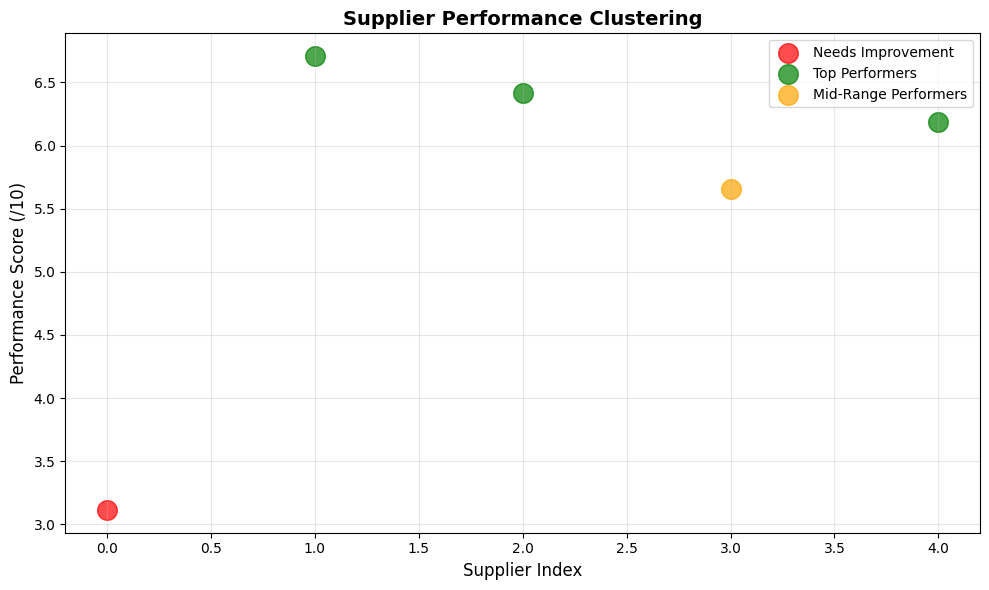


📈 ÉTAPE 3: Calcul de la Nouvelle Allocation Fournisseur

📊 Allocations par scénario:
  supplier  performance_category current_allocation new_allocation_conservative new_allocation_aggressive new_allocation_risk_mitigation
0    APEX      Needs Improvement             57.20%                      49.92%                    42.18%                         36.04%
1   BLITZ         Top Performers              1.84%                       2.17%                     2.54%                          2.78%
2  ZENITH         Top Performers             34.73%                      41.01%                    48.02%                         52.51%
3   MAREA   Mid-Range Performers              2.96%                       3.04%                     2.73%                          3.73%
4    KALA         Top Performers              3.27%                       3.86%                     4.52%                          4.94%

💰 ÉTAPE 4: Calcul des Savings Générés

🎯 Scénario: CONSERVATIVE
   Coût portefeuille actuel

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Téléchargement du fichier en cours...

✅ ANALYSE TERMINÉE AVEC SUCCÈS


In [3]:
"""
supplier_portfolio_analysis
Analyse complète de performance fournisseurs avec clustering et optimisation d'allocation
"""

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io

# ==================== CONFIGURATION ====================
print("=" * 70)
print("supplier_portfolio_analysis")
print("=" * 70)

# ==================== STEP 0: IMPORT DATA ====================
print("\n📂 ÉTAPE 0: Import des données")
print("-" * 70)

uploaded = files.upload()
filename = list(uploaded.keys())[0]

if filename.endswith('.csv'):
    df = pd.read_csv(io.BytesIO(uploaded[filename]))
elif filename.endswith(('.xlsx', '.xls')):
    df = pd.read_excel(io.BytesIO(uploaded[filename]))
else:
    raise ValueError("Format non supporté. Utilisez CSV ou Excel (.xlsx, .xls)")

print(f"✅ Fichier '{filename}' importé avec succès")
print(f"📊 Dimensions: {df.shape[0]} fournisseurs × {df.shape[1]} colonnes\n")

# Nettoyage des noms de colonnes (espaces, majuscules)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
print("🧹 Noms de colonnes nettoyés:")
print(f"   {list(df.columns)}\n")
print(df.head())

# Vérification des colonnes requises
required_cols = ['supplier', 'country', 'yearly_turnover_$', 'yearly_turnover_unit',
                 'po_volume_yearly', 'avg_quantity_per_po', 'freigth_cost_per_po',
                 'unit_cost_1_to_100', 'unit_cost_100_to_1000', 'unit_cost_over_1000',
                 'conformity_rate_per_po', 'otd_per_po']

missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Colonnes manquantes: {missing_cols}")


# ==================== FONCTIONS UTILITAIRES ====================
def normalize_0_10(series, inverse=False):
    """Normalise une série entre 0 et 10. Si inverse=True, inverse l'échelle."""
    min_val = series.min()
    max_val = series.max()

    if min_val == max_val:
        return pd.Series([5.0] * len(series), index=series.index)

    normalized = 10 * (series - min_val) / (max_val - min_val)

    if inverse:
        normalized = 10 - normalized

    return normalized


# ==================== STEP 1: CALCUL SCORE DE PERFORMANCE ====================
print("\n" + "=" * 70)
print("📊 ÉTAPE 1: Calcul du Score de Performance")
print("=" * 70)

# 1a - Détermination du coût unitaire appliqué
def get_unit_cost_applied(row):
    qty = row['avg_quantity_per_po']
    if qty <= 100:
        return row['unit_cost_1_to_100']
    elif qty <= 1000:
        return row['unit_cost_100_to_1000']
    else:
        return row['unit_cost_over_1000']

df['unit_cost_applied'] = df.apply(get_unit_cost_applied, axis=1)

# Coût unitaire total
df['unit_cost_total'] = df['yearly_turnover_unit'] * df['unit_cost_applied']
df['unit_cost_total_norm'] = normalize_0_10(df['unit_cost_total'], inverse=True)

# Coût de transport total
df['freight_total_cost'] = df['freigth_cost_per_po'] * df['po_volume_yearly']
df['freight_total_cost_norm'] = normalize_0_10(df['freight_total_cost'], inverse=True)

# Coût de non-qualité
df['non_quality_cost'] = (1 - df['conformity_rate_per_po']) * df['unit_cost_applied'] * df['yearly_turnover_unit']
df['non_quality_cost_norm'] = normalize_0_10(df['non_quality_cost'], inverse=True)

# Performance prix
df['price_performance'] = (df['unit_cost_total_norm'] * 0.8 +
                           df['freight_total_cost_norm'] * 0.05 +
                           df['non_quality_cost_norm'] * 0.15)
df['price_performance_norm'] = normalize_0_10(df['price_performance'])

print("\n💰 1a - Total Cost Performance")
print(df[['supplier', 'unit_cost_applied', 'unit_cost_total', 'freight_total_cost', 'non_quality_cost']].to_string())

# 1b - Taux de remise progressive
df['discount_1'] = (df['unit_cost_1_to_100'] - df['unit_cost_100_to_1000']) / df['unit_cost_1_to_100'] * 100
df['discount_2'] = (df['unit_cost_100_to_1000'] - df['unit_cost_over_1000']) / df['unit_cost_100_to_1000'] * 100
df['progressive_discount_rate'] = df['discount_1'] + df['discount_2']
df['progressive_discount_rate_norm'] = normalize_0_10(df['progressive_discount_rate'])

# Total cost performance
df['total_cost_performance'] = (df['progressive_discount_rate_norm'] * 0.2 +
                                 df['price_performance_norm'] * 0.8)

print("\n📉 1b - Progressive Discount Rate")
print(df[['supplier', 'discount_1', 'discount_2', 'progressive_discount_rate']].to_string())

# 1c - Quality performance (z-score normalisé)
avg_quality = df['conformity_rate_per_po'].mean()
std_quality = df['conformity_rate_per_po'].std()

if std_quality == 0:
    df['quality_performance'] = 0
else:
    df['quality_performance'] = (df['conformity_rate_per_po'] - avg_quality) / std_quality

df['quality_performance_norm'] = normalize_0_10(df['quality_performance'])

print(f"\n✅ 1c - Quality Performance (moyenne: {avg_quality:.2%}, σ: {std_quality:.4f})")
print(df[['supplier', 'conformity_rate_per_po', 'quality_performance_norm']].to_string())

# 1d - Delivery performance (z-score normalisé)
avg_otd = df['otd_per_po'].mean()
std_otd = df['otd_per_po'].std()

if std_otd == 0:
    df['delivery_performance'] = 0
else:
    df['delivery_performance'] = (df['otd_per_po'] - avg_otd) / std_otd

df['delivery_performance_norm'] = normalize_0_10(df['delivery_performance'])

print(f"\n🚚 1d - Delivery Performance (moyenne OTD: {avg_otd:.2%}, σ: {std_otd:.4f})")
print(df[['supplier', 'otd_per_po', 'delivery_performance_norm']].to_string())

# 1e - Score de performance global
df['total_score_performance'] = (df['total_cost_performance'] * 0.6 +
                                  df['quality_performance_norm'] * 0.2 +
                                  df['delivery_performance_norm'] * 0.2)

print("\n🎯 1e - SCORE DE PERFORMANCE GLOBAL (/10)")
print("-" * 70)
performance_summary = df[['supplier', 'total_cost_performance', 'quality_performance_norm',
                          'delivery_performance_norm', 'total_score_performance']].round(2)
print(performance_summary.to_string())


# ==================== STEP 2: CLUSTERING ML ====================
print("\n" + "=" * 70)
print("🤖 ÉTAPE 2: Clustering Machine Learning (KMeans)")
print("=" * 70)

# Préparation des données pour clustering
X = df[['total_score_performance']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans avec 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Attribution des labels basés sur le score moyen par cluster
cluster_means = df.groupby('cluster')['total_score_performance'].mean().sort_values()
cluster_labels = {
    cluster_means.index[0]: 'Needs Improvement',
    cluster_means.index[1]: 'Mid-Range Performers',
    cluster_means.index[2]: 'Top Performers'
}

df['performance_category'] = df['cluster'].map(cluster_labels)

print("\n📊 Résultats du clustering:")
clustering_results = df[['supplier', 'total_score_performance', 'performance_category']].sort_values('total_score_performance', ascending=False)
print(clustering_results.to_string())

# Visualisation
plt.figure(figsize=(10, 6))
colors = {'Top Performers': 'green', 'Mid-Range Performers': 'orange', 'Needs Improvement': 'red'}
for category in df['performance_category'].unique():
    mask = df['performance_category'] == category
    plt.scatter(df[mask].index, df[mask]['total_score_performance'],
               c=colors[category], label=category, s=200, alpha=0.7)

plt.xlabel('Supplier Index', fontsize=12)
plt.ylabel('Performance Score (/10)', fontsize=12)
plt.title('Supplier Performance Clustering', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ==================== STEP 3: NOUVELLE ALLOCATION FOURNISSEUR ====================
print("\n" + "=" * 70)
print("📈 ÉTAPE 3: Calcul de la Nouvelle Allocation Fournisseur")
print("=" * 70)

# Allocation actuelle
total_purchase_volume = df['yearly_turnover_$'].sum()
df['current_allocation'] = df['yearly_turnover_$'] / total_purchase_volume

# Facteurs d'allocation par scénario
factors = {
    'conservative': {'Top Performers': 1.15, 'Mid-Range Performers': 1.0, 'Needs Improvement': 0.85},
    'aggressive': {'Top Performers': 1.5, 'Mid-Range Performers': 1.0, 'Needs Improvement': 0.8},
    'risk_mitigation': {'Top Performers': 1.2, 'Mid-Range Performers': 1.0, 'Needs Improvement': 0.5}
}

# Calcul des nouvelles allocations
for scenario, factor_dict in factors.items():
    df[f'factor_{scenario}'] = df['performance_category'].map(factor_dict)
    df[f'weighted_{scenario}'] = df['current_allocation'] * df[f'factor_{scenario}']

    # Normalisation pour que la somme = 100%
    total_weighted = df[f'weighted_{scenario}'].sum()
    df[f'new_allocation_{scenario}'] = df[f'weighted_{scenario}'] / total_weighted

print("\n📊 Allocations par scénario:")
allocation_cols = ['supplier', 'performance_category', 'current_allocation',
                   'new_allocation_conservative', 'new_allocation_aggressive', 'new_allocation_risk_mitigation']
allocation_results = df[allocation_cols].copy()
for col in allocation_cols[2:]:
    allocation_results[col] = allocation_results[col].apply(lambda x: f"{x:.2%}")
print(allocation_results.to_string())


# ==================== STEP 4: CALCUL DES SAVINGS ====================
print("\n" + "=" * 70)
print("💰 ÉTAPE 4: Calcul des Savings Générés")
print("=" * 70)

# Coût total par fournisseur
df['supplier_total_cost'] = df['unit_cost_total'] + df['freight_total_cost'] + df['non_quality_cost']

# Commandes en retard
df['late_orders'] = (1 - df['otd_per_po']) * df['po_volume_yearly']

# Coût total du portefeuille actuel
portfolio_cost_current = (df['supplier_total_cost'] * df['current_allocation']).sum()

# Calcul des savings par scénario
savings_results = {}

for scenario in ['conservative', 'aggressive', 'risk_mitigation']:
    # Coût total avec nouvelle allocation
    portfolio_cost_new = (df['supplier_total_cost'] * df[f'new_allocation_{scenario}']).sum()

    # Savings globaux
    savings_absolute = portfolio_cost_current - portfolio_cost_new
    savings_percent = (savings_absolute / portfolio_cost_current) * 100

    # Savings sur non-qualité
    nq_cost_current = (df['non_quality_cost'] * df['current_allocation']).sum()
    nq_cost_new = (df['non_quality_cost'] * df[f'new_allocation_{scenario}']).sum()
    savings_nq = nq_cost_current - nq_cost_new

    # Delta commandes en retard
    late_current = (df['late_orders'] * df['current_allocation']).sum()
    late_new = (df['late_orders'] * df[f'new_allocation_{scenario}']).sum()
    delta_late = late_current - late_new

    savings_results[scenario] = {
        'portfolio_cost_current': portfolio_cost_current,
        'portfolio_cost_new': portfolio_cost_new,
        'savings_absolute': savings_absolute,
        'savings_percent': savings_percent,
        'savings_non_quality': savings_nq,
        'delta_late_orders': delta_late
    }

    print(f"\n🎯 Scénario: {scenario.upper()}")
    print(f"   Coût portefeuille actuel: ${portfolio_cost_current:,.2f}")
    print(f"   Coût portefeuille optimisé: ${portfolio_cost_new:,.2f}")
    print(f"   💵 Savings: ${savings_absolute:,.2f} ({savings_percent:+.2f}%)")
    print(f"   ✅ Réduction coûts non-qualité: ${savings_nq:,.2f}")
    print(f"   🚚 Réduction commandes en retard: {delta_late:,.0f} commandes")


# ==================== STEP 5: EXPORT EXCEL MULTI-ONGLETS ====================
print("\n" + "=" * 70)
print("📁 ÉTAPE 5: Export Excel Multi-Onglets")
print("=" * 70)

# Préparation du fichier Excel
output_filename = 'Monte_Carlo_Supplier_Analysis_Results.xlsx'

with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:

    # Onglet 1: Vue d'ensemble
    overview = df[[
        'supplier', 'country', 'performance_category', 'total_score_performance',
        'total_cost_performance', 'quality_performance_norm', 'delivery_performance_norm',
        'current_allocation', 'supplier_total_cost', 'non_quality_cost', 'late_orders'
    ]].copy()
    overview['current_allocation'] = overview['current_allocation'] * 100
    overview.to_excel(writer, sheet_name='Overview', index=False)

    # Onglet 2: Allocations détaillées
    allocations = df[[
        'supplier', 'performance_category', 'current_allocation',
        'new_allocation_conservative', 'new_allocation_aggressive', 'new_allocation_risk_mitigation'
    ]].copy()
    for col in ['current_allocation', 'new_allocation_conservative', 'new_allocation_aggressive', 'new_allocation_risk_mitigation']:
        allocations[col] = allocations[col] * 100
    allocations.to_excel(writer, sheet_name='Allocations', index=False)

    # Onglet 3: Détail des coûts
    costs = df[[
        'supplier', 'unit_cost_total', 'freight_total_cost', 'non_quality_cost',
        'supplier_total_cost', 'late_orders'
    ]].copy()
    costs.to_excel(writer, sheet_name='Cost_Details', index=False)

    # Onglet 4: Savings summary
    savings_df = pd.DataFrame(savings_results).T
    savings_df.index.name = 'Scenario'
    savings_df.to_excel(writer, sheet_name='Savings_Summary')

    # Onglet 5: Performance metrics
    metrics = df[[
        'supplier', 'unit_cost_applied', 'progressive_discount_rate',
        'conformity_rate_per_po', 'otd_per_po',
        'price_performance_norm', 'quality_performance_norm', 'delivery_performance_norm'
    ]].copy()
    metrics.to_excel(writer, sheet_name='Performance_Metrics', index=False)

print(f"✅ Fichier Excel créé: {output_filename}")

# Téléchargement du fichier
files.download(output_filename)
print(f"📥 Téléchargement du fichier en cours...")

print("\n" + "=" * 70)
print("✅ ANALYSE TERMINÉE AVEC SUCCÈS")
print("=" * 70)